In [31]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Usando dispositivo: {device}")

start_time_total = time.time()

train_df = pd.read_csv("mitbih_train.csv", header=None)
test_df = pd.read_csv("mitbih_test.csv", header=None)

Usando dispositivo: cpu


In [33]:
X_train = train_df.iloc[:, :-1].values
y_train = train_df.iloc[:, -1].astype(int).values

X_test = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:, -1].astype(int).values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256)

In [34]:
class ECGNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ECGNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        return self.fc3(x)

model = ECGNet(X_train.shape[1], 5).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
print("\nEntrenando...\n")
for epoch in range(epochs):
    epoch_start = time.time()
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    epoch_time = time.time() - epoch_start
    print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss/len(train_loader):.4f} - Tiempo: {epoch_time:.2f} s")


Entrenando...

Epoch 1/10 - Loss: 0.2962 - Tiempo: 0.81 s
Epoch 2/10 - Loss: 0.1415 - Tiempo: 0.80 s
Epoch 3/10 - Loss: 0.1126 - Tiempo: 0.77 s
Epoch 4/10 - Loss: 0.0974 - Tiempo: 1.04 s
Epoch 5/10 - Loss: 0.0881 - Tiempo: 0.73 s
Epoch 6/10 - Loss: 0.0818 - Tiempo: 0.84 s
Epoch 7/10 - Loss: 0.0770 - Tiempo: 0.80 s
Epoch 8/10 - Loss: 0.0725 - Tiempo: 0.83 s
Epoch 9/10 - Loss: 0.0678 - Tiempo: 0.75 s
Epoch 10/10 - Loss: 0.0646 - Tiempo: 0.77 s



Evaluando modelo...

Accuracy: 0.9754

Reporte de clasificación:

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     18118
           1       0.88      0.67      0.76       556
           2       0.92      0.94      0.93      1448
           3       0.80      0.64      0.71       162
           4       0.97      0.97      0.97      1608

    accuracy                           0.98     21892
   macro avg       0.91      0.84      0.87     21892
weighted avg       0.97      0.98      0.97     21892



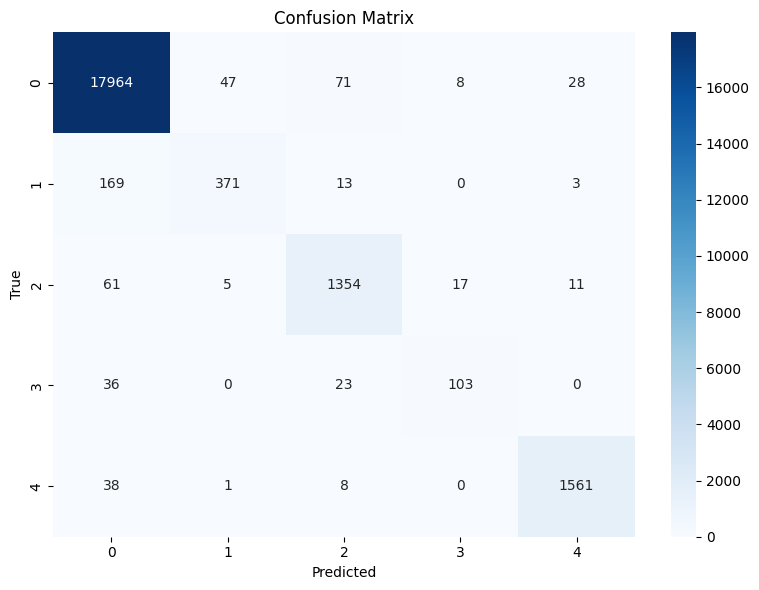


Tiempo de evaluación: 0.11 segundos

 Tiempo total de ejecución: 11.02 segundos


In [35]:
print("\nEvaluando modelo...")
model.eval()
y_pred = []
y_true = []

eval_start_time = time.time()

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(y_batch.numpy())

eval_time = time.time() - eval_start_time
y_pred = np.array(y_pred)
y_true = np.array(y_true)
accuracy = np.mean(y_pred == y_true)
print(f"\nAccuracy: {accuracy:.4f}")

print("\nReporte de clasificación:\n")
print(classification_report(y_true, y_pred))

conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="Blues",
            xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

total_time = time.time() - start_time_total
print(f"\nTiempo de evaluación: {eval_time:.2f} segundos")
print(f"\n Tiempo total de ejecución: {total_time:.2f} segundos")

In [36]:
torch.save(model.state_dict(), "ecg_model.pth")
print("Modelo guardado como 'ecg_model.pth'")

Modelo guardado como 'ecg_model.pth'
